In [1]:
import sys
import keras
import skimage

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from skimage.measure import compare_ssim as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os

import matplotlib
%matplotlib inline

Using TensorFlow backend.


In [0]:
# define a function for peak signal-to-noise ratio (PSNR)
def psnr(img1, img2):
  mse = np.mean( (img1.astype(float) - img2.astype(float)) ** 2 )
  if mse == 0:
    return 100
  PIXEL_MAX = 255.0
  return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def mse(target, ref):
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    return err

In [0]:
def prepare_images(path, factor):

    for file in os.listdir(path):
        img = cv2.imread(path + '/' + file)
        h, w, _ = img.shape
        
        new_height = h // factor
        new_width = w // factor
        
        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
        print('Saving {}'.format(file))
        cv2.imwrite('/content/images1/{}'.format(file), img)

In [4]:
prepare_images('/content/T91/', 3)

Saving face.bmp
Saving baboon.bmp
Saving flowers.bmp
Saving man.bmp
Saving foreman.bmp
Saving bridge.bmp
Saving barbara.bmp
Saving lenna.bmp
Saving zebra.bmp
Saving comic.bmp
Saving pepper.bmp
Saving ppt3.bmp
Saving monarch.bmp
Saving coastguard.bmp


In [5]:
for file in os.listdir('/content/images1/'):
    low = cv2.imread('/content/images1/{}'.format(file))
    high = cv2.imread('/content/T91/{}'.format(file))
    print(file)
    print('PSNR: ', "{:.4f}".format(psnr(low, high)), '  MSE: ', "{:.4f}".format(mse(low, high)), '  SSIM: ', "{:.4f}".format(ssim(low, high, multichannel =True)))

face.bmp
PSNR:  28.7473   MSE:  260.3010   SSIM:  0.7186
baboon.bmp
PSNR:  20.0518   MSE:  1927.6173   SSIM:  0.5007
flowers.bmp
PSNR:  24.8859   MSE:  633.2998   SSIM:  0.7894
man.bmp


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """


PSNR:  25.1372   MSE:  597.7039   SSIM:  0.7357
foreman.bmp
PSNR:  27.1036   MSE:  380.0505   SSIM:  0.8865
bridge.bmp
PSNR:  23.6163   MSE:  848.3433   SSIM:  0.6614
barbara.bmp
PSNR:  23.4474   MSE:  881.9873   SSIM:  0.7307
lenna.bmp
PSNR:  29.2251   MSE:  233.1825   SSIM:  0.7875
zebra.bmp
PSNR:  24.5627   MSE:  682.2277   SSIM:  0.7871
comic.bmp
PSNR:  21.1683   MSE:  1490.6479   SSIM:  0.7093
pepper.bmp
PSNR:  27.1920   MSE:  372.3949   SSIM:  0.7906
ppt3.bmp
PSNR:  21.7772   MSE:  1295.6410   SSIM:  0.8747
monarch.bmp
PSNR:  27.3914   MSE:  355.6850   SSIM:  0.9075
coastguard.bmp
PSNR:  24.1894   MSE:  743.4590   SSIM:  0.6097


In [0]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [7]:
srcnn = Sequential()
    
srcnn.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
srcnn.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
srcnn.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
adam = Adam(lr=0.0003)
srcnn.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
def predict(image_path):
    #srcnn = model()
    srcnn.load_weights('/content/3051crop_weight_200.h5')
    
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('/content/T91/{}'.format(file))
    
    #ref = modcrop(ref, 3)
    #degraded = modcrop(degraded, 3)
    
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    Y = np.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    pre = srcnn.predict(Y, batch_size=1)
    
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    temp = temp[6: -6, 6: -6]
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
    ref1 = ref.astype(np.uint8)
    degraded1 = degraded.astype(np.uint8)
    ref = ref1[6: -6, 6: -6]
    degraded = degraded1[6: -6, 6: -6]
    
    return ref, degraded, output

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  after removing the cwd from sys.path.


Degraded Image: 
PSNR:  20.2730   MSE:  1831.9078   SSIM:  0.5043
Reconstructed Image: 
PSNR:  19.8378   MSE:  2024.9989   SSIM:  0.5203


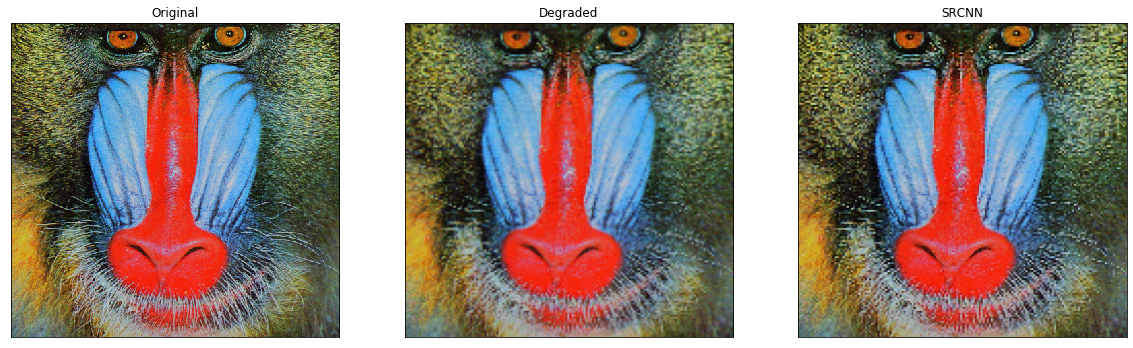

In [9]:
ref, degraded, output = predict('/content/images1/baboon.bmp')

print('Degraded Image: \nPSNR: ', "{:.4f}".format(psnr(degraded, ref)), '  MSE: ', "{:.4f}".format(mse(degraded, ref)), '  SSIM: ', "{:.4f}".format(ssim(degraded, ref, multichannel =True)))
print('Reconstructed Image: \nPSNR: ', "{:.4f}".format(psnr(output, ref)), '  MSE: ', "{:.4f}".format(mse(output, ref)), '  SSIM: ', "{:.4f}".format(ssim(output, ref, multichannel =True)))
#print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
#print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))

fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [10]:
for file in os.listdir('/content/images1'):
    
    # perform super-resolution
    ref, degraded, output = predict('/content/images1/{}'.format(file))
    
    # display images as subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(psnr(degraded, ref), mse(degraded, ref), ssim(degraded, ref, multichannel =True)))
    axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[2].set_title('SRCNN')
    axs[2].set(xlabel = 'PSNR: {} \nMSE: {} \nSSIM: {}'.format(psnr(output, ref), mse(output, ref), ssim(output, ref, multichannel =True)))

    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
      
    print('Saving {}'.format(file))
    fig.savefig('/content/output1/{}.png'.format(os.path.splitext(file)[0])) 
    plt.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  from ipykernel import kernelapp as app


Saving face.bmp
Saving baboon.bmp
Saving flowers.bmp
Saving man.bmp
Saving foreman.bmp
Saving bridge.bmp
Saving barbara.bmp
Saving lenna.bmp
Saving zebra.bmp
Saving comic.bmp
Saving pepper.bmp
Saving ppt3.bmp
Saving monarch.bmp
Saving coastguard.bmp
